<a href="https://colab.research.google.com/github/thanhnguyen2612/diveintocode-ml/blob/master/ML_sprint4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression

In [300]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [301]:
class ScratchLogisticRegression():
    """
    Scratch implementation of logistic regression
    Parameters
    ----------
    num_iter : int
      Number of iterations
    lr : float
      Learning rate
    bias : bool
      True if bias term is included
    verbose : bool
      True to output the learning process
    Attributes
    ----------
    self.coef_ : The following form of ndarray, shape (n_features,)
      Parameters
    self.loss : The following form of ndarray, shape (self.iter,)
      Record losses on training data
    self.val_loss : The following form of ndarray, shape (self.iter,)
      Record loss on validation data
    """
    def __init__(self, num_iter=100, lr=0.01, C=1.0, 
                 bias=True, verbose=False, random_state=None):
        # Record hyperparameters as attributes
        self.iter = num_iter
        self.lr = lr
        self.bias = bias
        self.verbose = verbose
        self.C = C
        self.random_state = random_state

        # Prepare an array to record the loss
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn logistic regression. If validation data is entered, the loss and accuracy for it are also calculated for each iteration.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        X_val : The following forms of ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form of ndarray, shape (n_samples,)
            Correct value of verification data
        """
        # Generalize labels
        self.ylabel = np.unique(y)
        y = np.where(y == self.ylabel[0], 0, 1)
        if y_val is not None:
            y_val = np.where(y_val == self.ylabel[0], 0, 1)

        # Add bias
        X = self._linear_combination(X)
        if X_val is not None:
            X_val = self._linear_combination(X_val)

        # Init thetas
        np.random.seed(self.random_state)
        self.coef_ = np.random.randn(X.shape[1])

        for i in range(self.iter):
            self._gradient_descent(X, y)

            self.loss[i] = self._objective_func(X, y)
            if X_val is not None and y_val is not None:
                self.val_loss[i] = self._objective_func(X_val, y_val)
            
            if self.verbose:
                # Output the learning process when verbose is set to True
                print('n_iter:', i, 'loss', self.loss[i], 'theta:', self.coef_)
        
        # Save the trained weights
        np.save('theta', self.coef_)

    def predict(self, X):
        """
        Estimate the label using logistic regression.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result by logistic regression
        """
        y_pred = self.predict_proba(X)
        return np.where(y_pred < 0.5, self.ylabel[0], self.ylabel[1])

    def predict_proba(self, X):
        """
        Estimate the probability using logistic regression.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result by logistic regression
        """
        X = self._linear_combination(X)
        return self._hypothetical_func(X)
    
    def _linear_combination(self, X):
        bias = np.ones(X.shape[0]) if self.bias else np.zeros(X.shape[0])
        return np.concatenate([bias.reshape(-1, 1), X], axis=1)
    
    def _hypothetical_func(self, X):
        z = X @ self.coef_
        h = 1 / (1 + np.exp(-z))
        return h
    
    def _gradient_descent(self, X, y):
        y_pred = self._hypothetical_func(X)

        # Compute gradients
        temp = np.append(0, np.ones(X.shape[1] - 1))
        grads = ((y_pred - y) @ X + temp * self.coef_ / self.C) / X.shape[0]

        # Gradient descent
        self.coef_ -= self.lr * grads
    
    def _objective_func(self, X, y):
        y_pred = self._hypothetical_func(X)
        cost = np.mean(-y*np.log(y_pred) - (1 - y)*np.log(1 - y_pred)) + 0.5 / self.C * np.mean(self.coef_[1:]**2)
        return cost

## [Problem 5] Learning and estimation

In [302]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

def preprocess(X, y, preprocessor=None, test_size=0.2, random_state=None):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size,
                                                      random_state=random_state)
    if preprocessor is not None:
        X_train = preprocessor.fit_transform(X_train)
        X_val = preprocessor.transform(X_val)
    return X_train, X_val, y_train, y_val

def train_and_validate(X_train, X_val, y_train, y_val, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))
    sns.heatmap(confusion_matrix(y_val, y_pred), cmap=plt.cm.Blues, annot=True)

### Load iris dataset

In [303]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

print(load_iris().target_names)
X, y = load_iris(return_X_y=True)
X, y = X[np.isin(y, [1, 2])], y[np.isin(y, [1, 2])]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

['setosa' 'versicolor' 'virginica']
(80, 4) (20, 4) (80,) (20,)


### Training and validating

              precision    recall  f1-score   support

           1       1.00      0.80      0.89        10
           2       0.83      1.00      0.91        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20



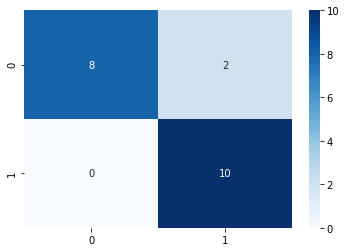

In [304]:
scratch_model = ScratchLogisticRegression(random_state=0)
train_and_validate(X_train, X_val, y_train, y_val, scratch_model)

              precision    recall  f1-score   support

           1       1.00      0.80      0.89        10
           2       0.83      1.00      0.91        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20



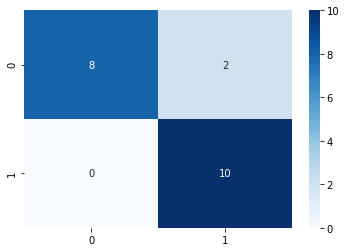

In [305]:
from sklearn.linear_model import LogisticRegression

sklearn_model = LogisticRegression(random_state=0)
train_and_validate(X_train, X_val, y_train, y_val, sklearn_model)

## [Problem 6] Plot of learning curve

In [306]:
def plot_learning_curve(train_loss, val_loss=None):
    plt.figure(figsize=(16, 8))
    plt.plot(train_loss, label="train_loss", linewidth=5)
    if val_loss is not None:
        plt.plot(val_loss, label="val_loss", linewidth=5)
    plt.xlabel("iter")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

def train_and_visualize(X_train, X_val, y_train, y_val, model):
    model.fit(X_train, y_train, X_val, y_val)
    plot_learning_curve(model.loss, model.val_loss)

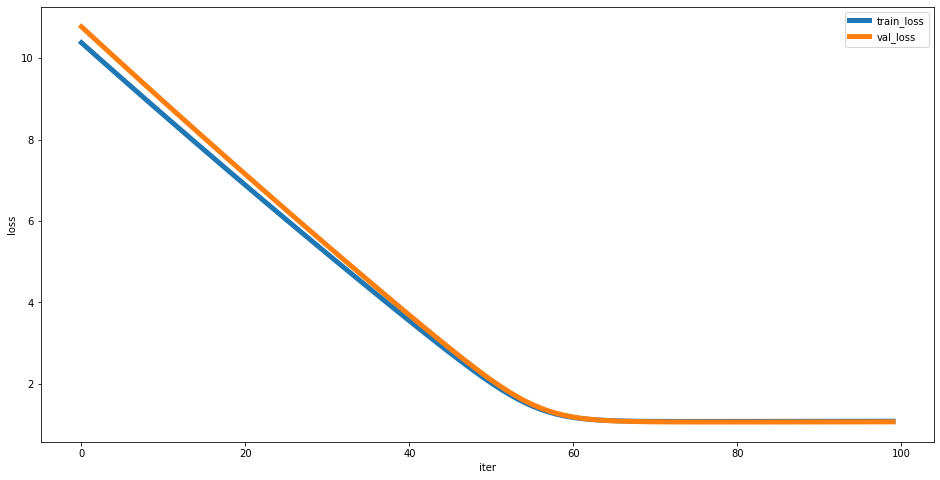

In [307]:
scratch_model = ScratchLogisticRegression(random_state=0)
train_and_visualize(X_train, X_val, y_train, y_val, scratch_model)

## [Problem 7] Visualization of decision area

In [308]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

def decision_region(X, y, model, step=0.01,
                    title="Decision region",
                    xlabel="xlabel",
                    ylabel="ylabel",
                    targets=[0, 1]):
    # Setting
    scatter_colors = ["red", "blue"]
    contourf_colors = ["pink", "skyblue"]
    n_class = len(targets)

    mesh_f0, mesh_f1 = np.meshgrid(np.arange(np.min(X[:,0]) - 0.5, np.max(X[:,0]) + 0.5, step),
                                   np.arange(np.min(X[:,1]) - 0.5, np.max(X[:,1]) + 0.5, step))
    mesh = np.c_[np.ravel(mesh_f0), np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    
    # Plot
    plt.figure(figsize=(16, 9))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class - 1, cmap=ListedColormap(contourf_colors))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class - 1, colors='y', alpha=0.5)

    for i, target in enumerate(set(y)):
        plt.scatter(X[y == target][:, 0], X[y == target][:, 1], s=80, 
                    color=scatter_colors[i], label=targets[i], marker='o')
    patches = [Patch(color=scatter_colors[i], label=targets[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

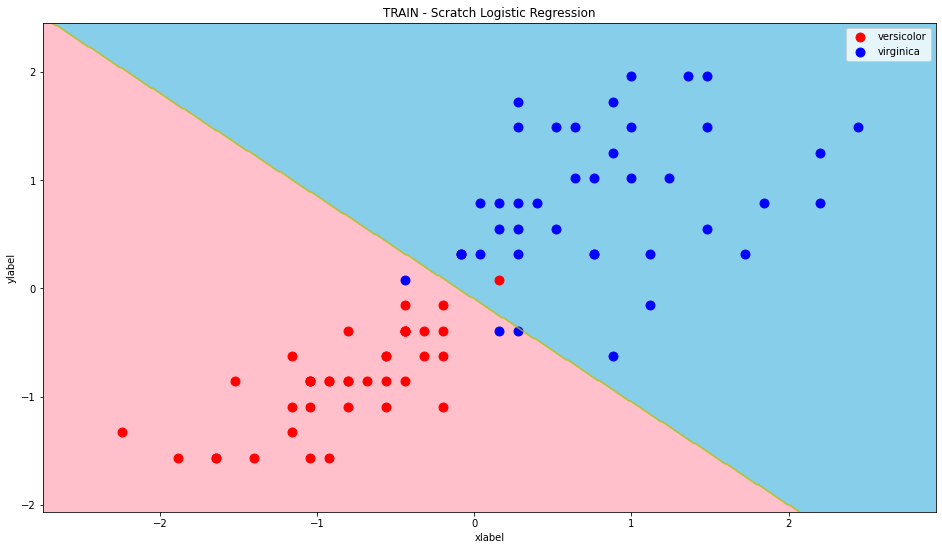

In [309]:
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = preprocess(X[:, 2:4], y, StandardScaler(), test_size=0.2, random_state=0)
clf1 = ScratchLogisticRegression(num_iter=5000, random_state=0)
clf1.fit(X_train, y_train, X_val, y_val)
decision_region(X_train, y_train, clf1, title="TRAIN - Scratch Logistic Regression", targets=["versicolor", "virginica"])

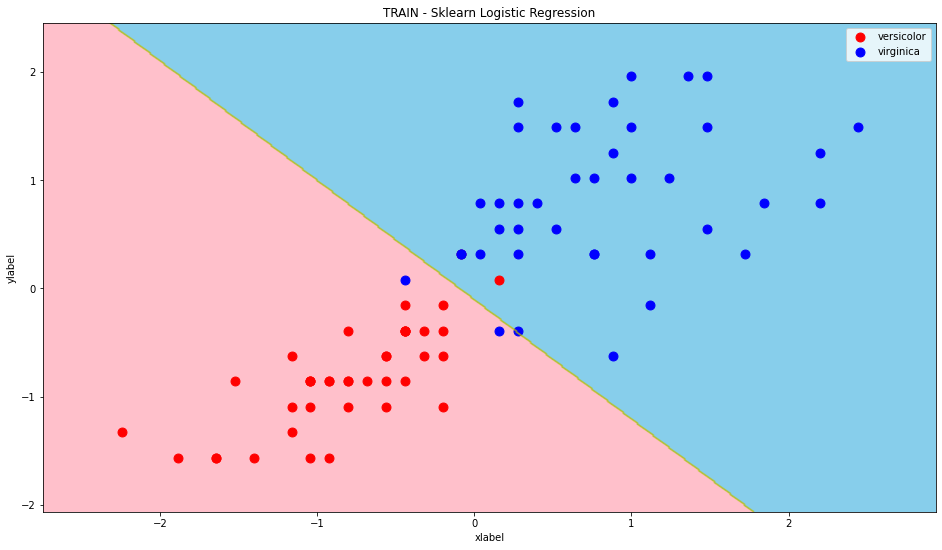

In [310]:
from sklearn.linear_model import LogisticRegression

clf2 = LogisticRegression(random_state=0)
clf2.fit(X_train, y_train)
decision_region(X_train, y_train, clf2, title="TRAIN - Sklearn Logistic Regression", targets=["versicolor", "virginica"])

## [Problem 8] (Advance assignment) Saving weights

In [311]:
np.load('theta.npy')

array([0.19778734, 1.92292755, 2.02272428])

In [312]:
import pickle

file1 = "scratch.sav"
file2 = "sklearn.sav"
pickle.dump(clf1, open(file1, "wb"))
pickle.dump(clf2, open(file2, "wb"))

              precision    recall  f1-score   support

           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



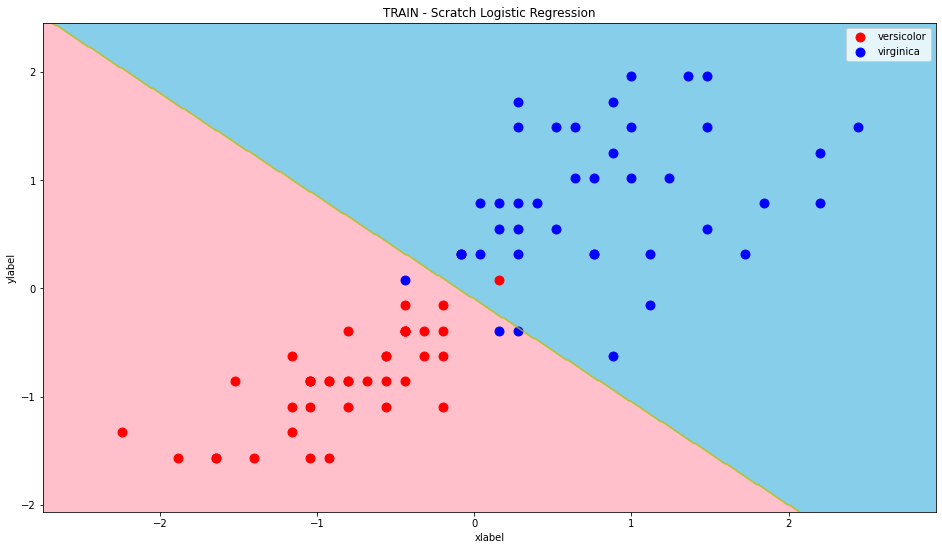

In [313]:
load_model1 = pickle.load(open(file1, "rb"))

y_pred = load_model1.predict(X_val)
print(classification_report(y_val, y_pred))
decision_region(X_train, y_train, load_model1,
                title="TRAIN - Scratch Logistic Regression",
                targets=["versicolor", "virginica"])

              precision    recall  f1-score   support

           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



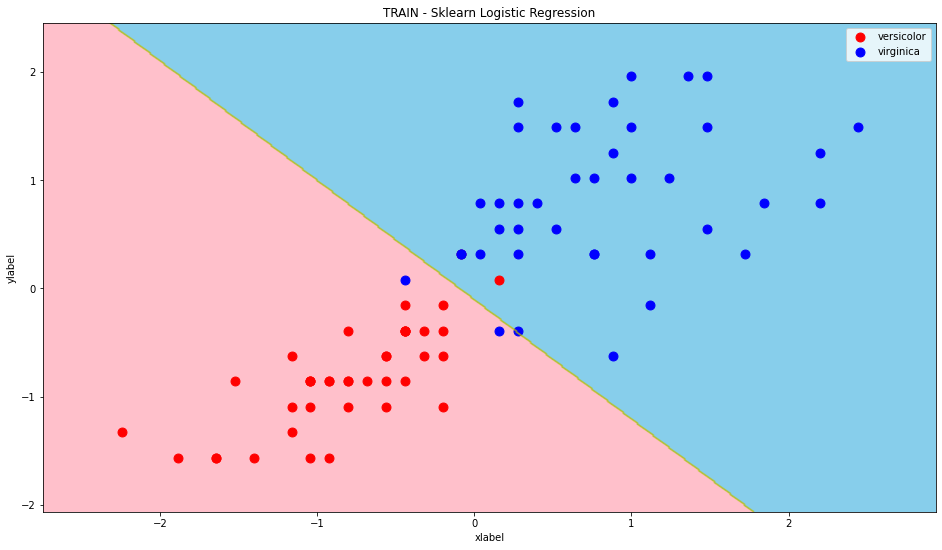

In [314]:
load_model2 = pickle.load(open(file2, "rb"))

y_pred = load_model2.predict(X_val)
print(classification_report(y_val, y_pred))
decision_region(X_train, y_train, load_model2,
                title="TRAIN - Sklearn Logistic Regression",
                targets=["versicolor", "virginica"])